In [1]:
import hashlib
import random
import math
import timeit
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def calculate_lcm(num1, num2):
    return abs(num1 * num2) // math.gcd(num1, num2)

def miller_rabin(candidate, rounds=5):
    if candidate in (2, 3):
        return True
    if candidate <= 1 or candidate % 2 == 0:
        return False
    r, s = 0, candidate - 1
    while s % 2 == 0:
        r += 1
        s //= 2
    for _ in range(rounds):
        a = random.randrange(2, candidate - 1)
        x = pow(a, s, candidate)
        if x in (1, candidate - 1):
            continue
        for _ in range(r - 1):
            x = pow(x, 2, candidate)
            if x == candidate - 1:
                break
        else:
            return False
    return True

def generate_prime(key_size):
    while True:
        num = random.getrandbits(key_size)
        if miller_rabin(num):
            return num

def compute_gcd(a, b):
    while b:
        a, b = b, a % b
    return a

def extended_gcd(a, b):
    x0, x1, y0, y1 = 1, 0, 0, 1
    while b:
        q, a, b = a // b, b, a % b
        x0, x1 = x1, x0 - q * x1
        y0, y1 = y1, y0 - q * y1
    return x0, y0

def modular_inverse(a, m):
    m0, x0, x1 = m, 0, 1
    if m == 1:
        return 0
    while a > 1:
        q = a // m
        m, a = a % m, m
        x0, x1 = x1 - q * x0, x0
    if x1 < 0:
        x1 += m0
    return x1

def hash_message(message):
    return hashlib.sha1(message.encode()).hexdigest()

In [10]:
def generate_keys_with_euler(key_size):
    p = generate_prime(key_size)
    q = generate_prime(key_size)
    modulus = p * q
    euler_totient = (p - 1) * (q - 1)
    public_key = find_public_key(euler_totient)
    private_key = find_private_key(public_key, euler_totient)
    return public_key, private_key, modulus, p, q

def generate_keys_with_carmichael(key_size):
    p = generate_prime(key_size)
    q = generate_prime(key_size)
    modulus = p * q
    carmichael_totient = calculate_lcm(p - 1, q - 1)
    public_key = find_public_key(carmichael_totient)
    private_key = find_private_key(public_key, carmichael_totient)
    return public_key, private_key, modulus, p, q

def find_public_key(totient):
    e = 2
    while compute_gcd(e, totient) != 1:
        e += 1
    return e

def find_private_key(public_key, totient):
    d, _ = extended_gcd(public_key, totient)
    return d % totient


In [4]:
def encrypt_message(message, public_key, modulus):
    return [pow(ord(char), public_key, modulus) for char in message]

def decrypt_message(encrypted_message, private_key, modulus):
    return ''.join([chr(pow(char, private_key, modulus)) for char in encrypted_message])

def crt_decrypt(encrypted_message, private_key, p, q):
    n = p * q
    d_p = private_key % (p - 1)
    d_q = private_key % (q - 1)
    q_inv = modular_inverse(q, p)
    
    decrypted_message = []
    for c in encrypted_message:
        m1 = pow(c, d_p, p)
        m2 = pow(c, d_q, q)
        h = (q_inv * (m1 - m2)) % p
        m = m2 + h * q
        decrypted_message.append(chr(m))
    
    return ''.join(decrypted_message)

In [5]:
def sign_message(message, private_key, modulus):
    hashed_message = hash_message(message)
    return [pow(ord(char), private_key, modulus) for char in hashed_message]

def verify_signature(message, signature, public_key, modulus):
    hashed_message = hash_message(message)
    decrypted_signature = ''.join([chr(pow(char, public_key, modulus)) for char in signature])
    return hashed_message == decrypted_signature


In [12]:
class Sender:
    def __init__(self, public_key, modulus):
        self.public_key = public_key
        self.modulus = modulus

    def send(self, message, private_key):
        encrypted_message = encrypt_message(message, self.public_key, self.modulus)
        signature = sign_message(message, private_key, self.modulus)
        return encrypted_message, signature

class Receiver:
    def __init__(self, private_key, public_key, modulus, p, q):
        self.private_key = private_key
        self.public_key = public_key
        self.modulus = modulus
        self.p = p
        self.q = q

    def receive_standard(self, encrypted_message, signature):
        decrypted_message = decrypt_message(encrypted_message, self.private_key, self.modulus)
        if verify_signature(decrypted_message, signature, self.public_key, self.modulus):
            print("Standard Decryption: Signature is valid.")
        else:
            print("Standard Decryption: Signature is invalid.")
        return decrypted_message

    def receive_crt(self, encrypted_message, signature):
        decrypted_message = crt_decrypt(encrypted_message, self.private_key, self.p, self.q)
        if verify_signature(decrypted_message, signature, self.public_key, self.modulus):
            print("CRT Decryption: Signature is valid.")
        else:
            print("CRT Decryption: Signature is invalid.")
        return decrypted_message

In [13]:
def measure_performance(key_size):
    # Measure key generation time
    start_time = timeit.default_timer()
    public_key, private_key, modulus, p, q = generate_keys_with_carmichael(key_size)
    key_gen_time = timeit.default_timer() - start_time

    message = "Performance Test"

    start_time = timeit.default_timer()
    encrypted_message = encrypt_message(message, public_key, modulus)
    encryption_time = timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    decrypted_message_standard = decrypt_message(encrypted_message, private_key, modulus)
    decryption_time_standard = timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    decrypted_message_crt = crt_decrypt(encrypted_message, private_key, p, q)
    decryption_time_crt = timeit.default_timer() - start_time

    return key_gen_time, encryption_time, decryption_time_standard, decryption_time_crt

In [17]:
def simulate_message_exchange():
    key_size = 256
    message = "I usually solve problems by letting them devour me."

    public_key_euler, private_key_euler, modulus_euler, p_euler, q_euler = generate_keys_with_euler(key_size)
    alice_euler = Sender(public_key_euler, modulus_euler)
    bob_euler = Receiver(private_key_euler, public_key_euler, modulus_euler, p_euler, q_euler)

    encrypted_message_euler, signature_euler = alice_euler.send(message, private_key_euler)
    decrypted_message_standard_euler = bob_euler.receive_standard(encrypted_message_euler, signature_euler)
    decrypted_message_crt_euler = bob_euler.receive_crt(encrypted_message_euler, signature_euler)

    public_key_carmichael, private_key_carmichael, modulus_carmichael, p_carmichael, q_carmichael = generate_keys_with_carmichael(key_size)
    alice_carmichael = Sender(public_key_carmichael, modulus_carmichael)
    bob_carmichael = Receiver(private_key_carmichael, public_key_carmichael, modulus_carmichael, p_carmichael, q_carmichael)

    encrypted_message_carmichael, signature_carmichael = alice_carmichael.send(message, private_key_carmichael)
    decrypted_message_standard_carmichael = bob_carmichael.receive_standard(encrypted_message_carmichael, signature_carmichael)
    decrypted_message_crt_carmichael = bob_carmichael.receive_crt(encrypted_message_carmichael, signature_carmichael)

    # Output results
    print()
    print("Encrypted message (Euler):", encrypted_message_euler)
    print("Decrypted message (Standard, Euler):", decrypted_message_standard_euler)
    print("Decrypted message (CRT, Euler):", decrypted_message_crt_euler)
    print()
    print("Encrypted message (Carmichael):", encrypted_message_carmichael)
    print("Decrypted message (Standard, Carmichael):", decrypted_message_standard_carmichael)
    print("Decrypted message (CRT, Carmichael):", decrypted_message_crt_carmichael)

simulate_message_exchange()


Standard Decryption: Signature is valid.
CRT Decryption: Signature is valid.
Standard Decryption: Signature is valid.
CRT Decryption: Signature is valid.

Encrypted message (Euler): [2073071593, 33554432, 21924480357, 20113571875, 21924480357, 8587340257, 14693280768, 14693280768, 25937424601, 33554432, 20113571875, 16850581551, 14693280768, 22877577568, 10510100501, 33554432, 17623416832, 19254145824, 16850581551, 9039207968, 14693280768, 10510100501, 15386239549, 20113571875, 33554432, 9039207968, 25937424601, 33554432, 14693280768, 10510100501, 21003416576, 21003416576, 12762815625, 16105100000, 11592740743, 33554432, 21003416576, 12166529024, 10510100501, 15386239549, 33554432, 10000000000, 10510100501, 22877577568, 16850581551, 21924480357, 19254145824, 33554432, 15386239549, 10510100501, 205962976]
Decrypted message (Standard, Euler): I usually solve problems by letting them devour me.
Decrypted message (CRT, Euler): I usually solve problems by letting them devour me.

Encrypted 

In [18]:
def measure_performance_with_euler(key_size):
    start_time = timeit.default_timer()
    public_key, private_key, modulus, p, q = generate_keys_with_euler(key_size)
    key_gen_time = timeit.default_timer() - start_time

    message = "Performance Test"

    start_time = timeit.default_timer()
    encrypted_message = encrypt_message(message, public_key, modulus)
    encryption_time = timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    decrypted_message_standard = decrypt_message(encrypted_message, private_key, modulus)
    decryption_time_standard = timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    decrypted_message_crt = crt_decrypt(encrypted_message, private_key, p, q)
    decryption_time_crt = timeit.default_timer() - start_time

    return key_gen_time, encryption_time, decryption_time_standard, decryption_time_crt

def measure_performance_with_carmichael(key_size):
    start_time = timeit.default_timer()
    public_key, private_key, modulus, p, q = generate_keys_with_carmichael(key_size)
    key_gen_time = timeit.default_timer() - start_time

    message = "Performance Test"

    start_time = timeit.default_timer()
    encrypted_message = encrypt_message(message, public_key, modulus)
    encryption_time = timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    decrypted_message_standard = decrypt_message(encrypted_message, private_key, modulus)
    decryption_time_standard = timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    decrypted_message_crt = crt_decrypt(encrypted_message, private_key, p, q)
    decryption_time_crt = timeit.default_timer() - start_time

    return key_gen_time, encryption_time, decryption_time_standard, decryption_time_crt

In [19]:
key_sizes = [128, 256, 512, 1024, 2048]
performance_results_euler = []
performance_results_carmichael = []

for key_size in key_sizes:
    performance_results_euler.append((key_size, *measure_performance_with_euler(key_size)))
    performance_results_carmichael.append((key_size, *measure_performance_with_carmichael(key_size)))

In [20]:
df_performance_euler = pd.DataFrame(performance_results_euler, columns=["Key Size", "Key Generation Time (s)", "Encryption Time (s)", "Decryption Time (Standard) (s)", "Decryption Time (CRT) (s)"])
df_performance_carmichael = pd.DataFrame(performance_results_carmichael, columns=["Key Size", "Key Generation Time (s)", "Encryption Time (s)", "Decryption Time (Standard) (s)", "Decryption Time (CRT) (s)"])

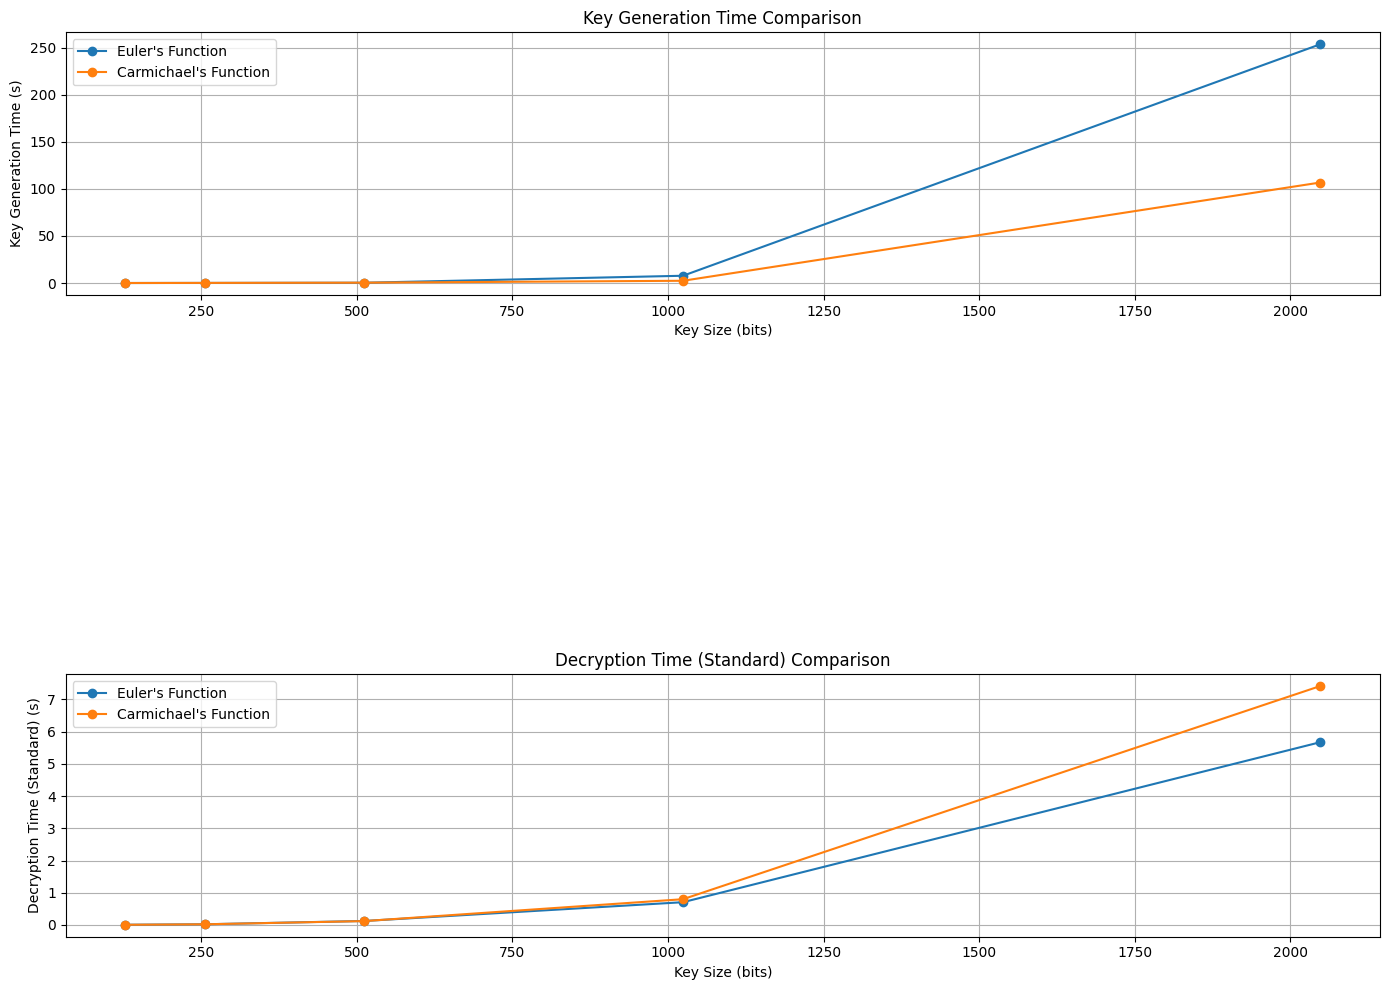

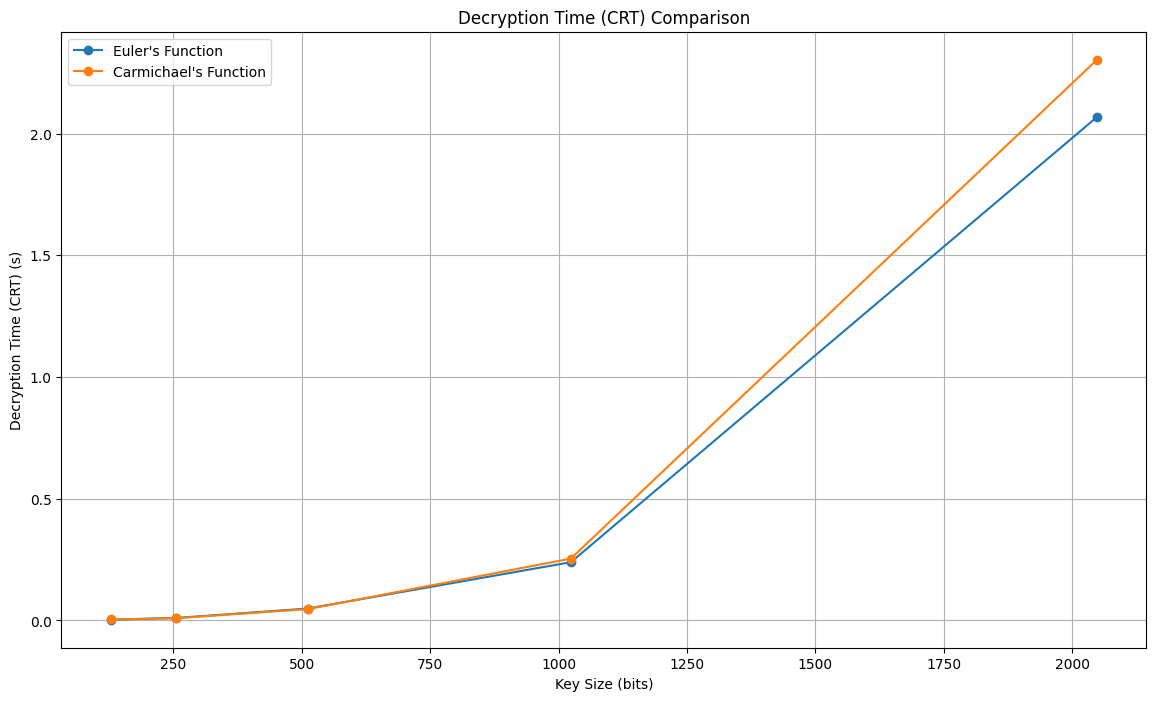

(   Key Size  Key Generation Time (s)  Encryption Time (s)  \
 0       128                 0.005856             0.000018   
 1       256                 0.095487             0.000017   
 2       512                 0.293597             0.000017   
 3      1024                 7.715702             0.000018   
 4      2048               253.763037             0.000020   
 
    Decryption Time (Standard) (s)  Decryption Time (CRT) (s)  
 0                        0.006178                   0.003085  
 1                        0.020724                   0.010420  
 2                        0.123431                   0.049049  
 3                        0.706205                   0.239418  
 4                        5.672447                   2.068274  ,
    Key Size  Key Generation Time (s)  Encryption Time (s)  \
 0       128                 0.004477             0.000019   
 1       256                 0.102408             0.000018   
 2       512                 0.360611             0.000

In [24]:
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Key Generation Time (s)"], marker='o', label="Euler's Function")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Key Generation Time (s)"], marker='o', label="Carmichael's Function")
plt.xlabel("Key Size (bits)")
plt.ylabel("Key Generation Time (s)")
plt.title("Key Generation Time Comparison")
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Decryption Time (Standard) (s)"], marker='o', label="Euler's Function")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Decryption Time (Standard) (s)"], marker='o', label="Carmichael's Function")
plt.xlabel("Key Size (bits)")
plt.ylabel("Decryption Time (Standard) (s)")
plt.title("Decryption Time (Standard) Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Decryption Time (CRT) (s)"], marker='o', label="Euler's Function")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Decryption Time (CRT) (s)"], marker='o', label="Carmichael's Function")
plt.xlabel("Key Size (bits)")
plt.ylabel("Decryption Time (CRT) (s)")
plt.title("Decryption Time (CRT) Comparison")
plt.legend()
plt.grid(True)
plt.show()

df_performance_euler, df_performance_carmichael

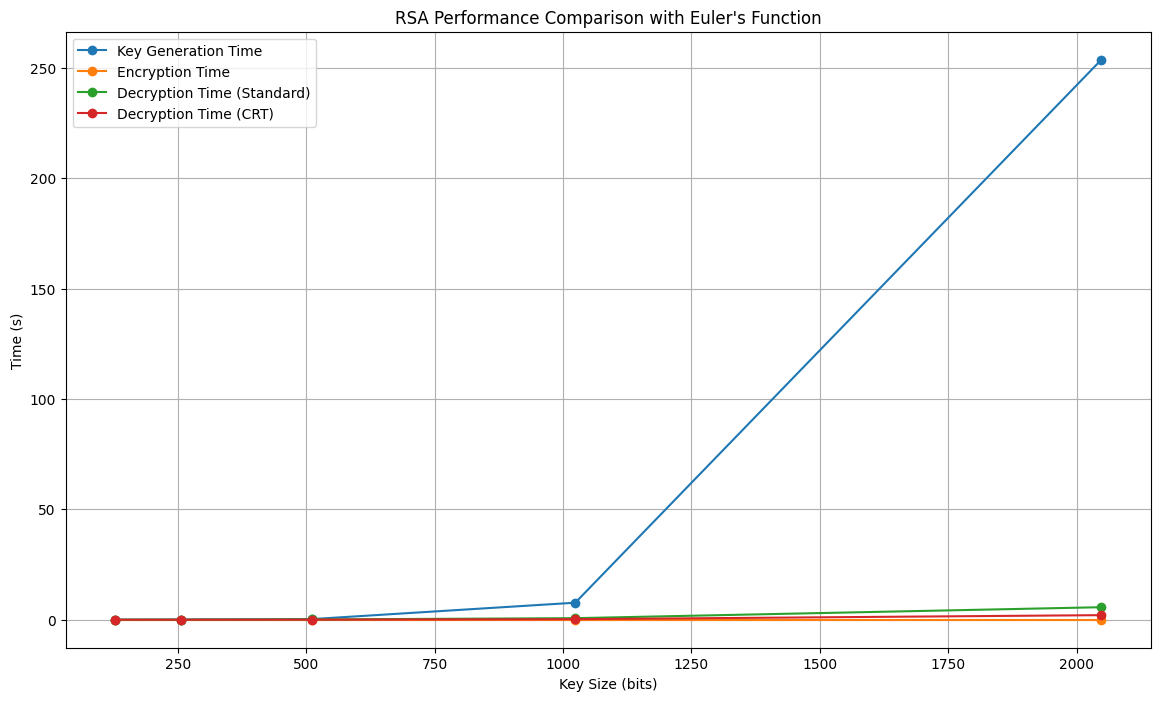

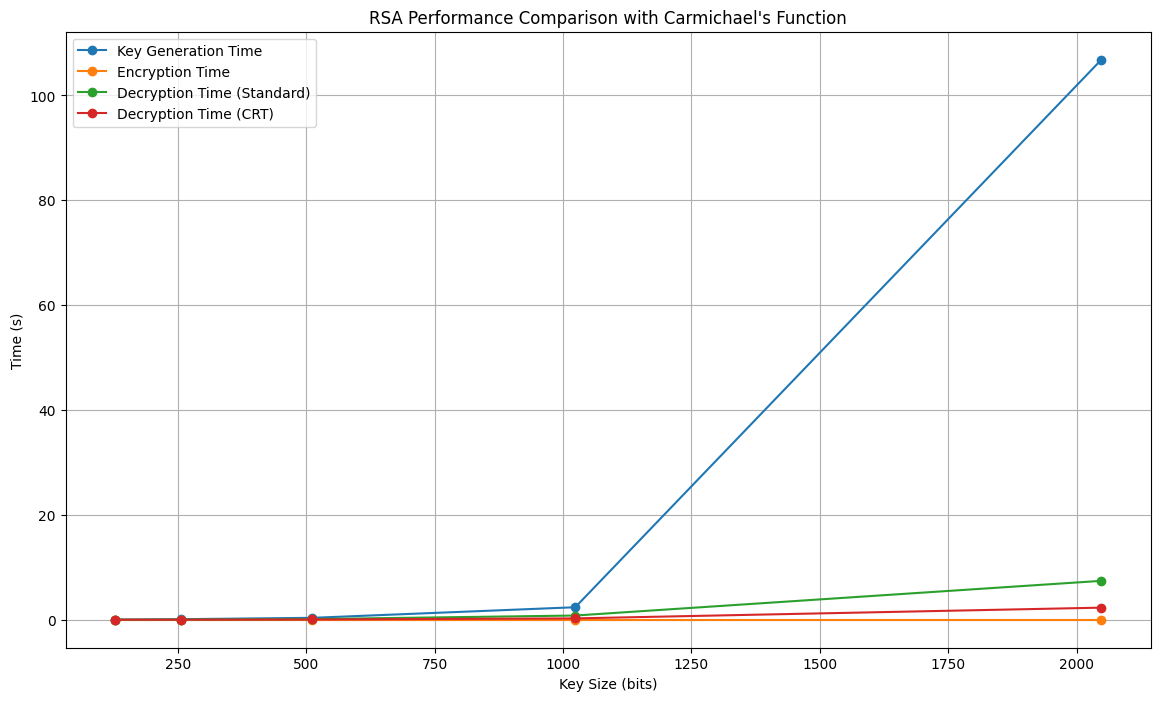

In [23]:
plt.figure(figsize=(14, 8))
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Key Generation Time (s)"], marker='o', label="Key Generation Time")
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Encryption Time (s)"], marker='o', label="Encryption Time")
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Decryption Time (Standard) (s)"], marker='o', label="Decryption Time (Standard)")
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Decryption Time (CRT) (s)"], marker='o', label="Decryption Time (CRT)")
plt.xlabel("Key Size (bits)")
plt.ylabel("Time (s)")
plt.title("RSA Performance Comparison with Euler's Function")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Key Generation Time (s)"], marker='o', label="Key Generation Time")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Encryption Time (s)"], marker='o', label="Encryption Time")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Decryption Time (Standard) (s)"], marker='o', label="Decryption Time (Standard)")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Decryption Time (CRT) (s)"], marker='o', label="Decryption Time (CRT)")
plt.xlabel("Key Size (bits)")
plt.ylabel("Time (s)")
plt.title("RSA Performance Comparison with Carmichael's Function")
plt.legend()
plt.grid(True)
plt.show()

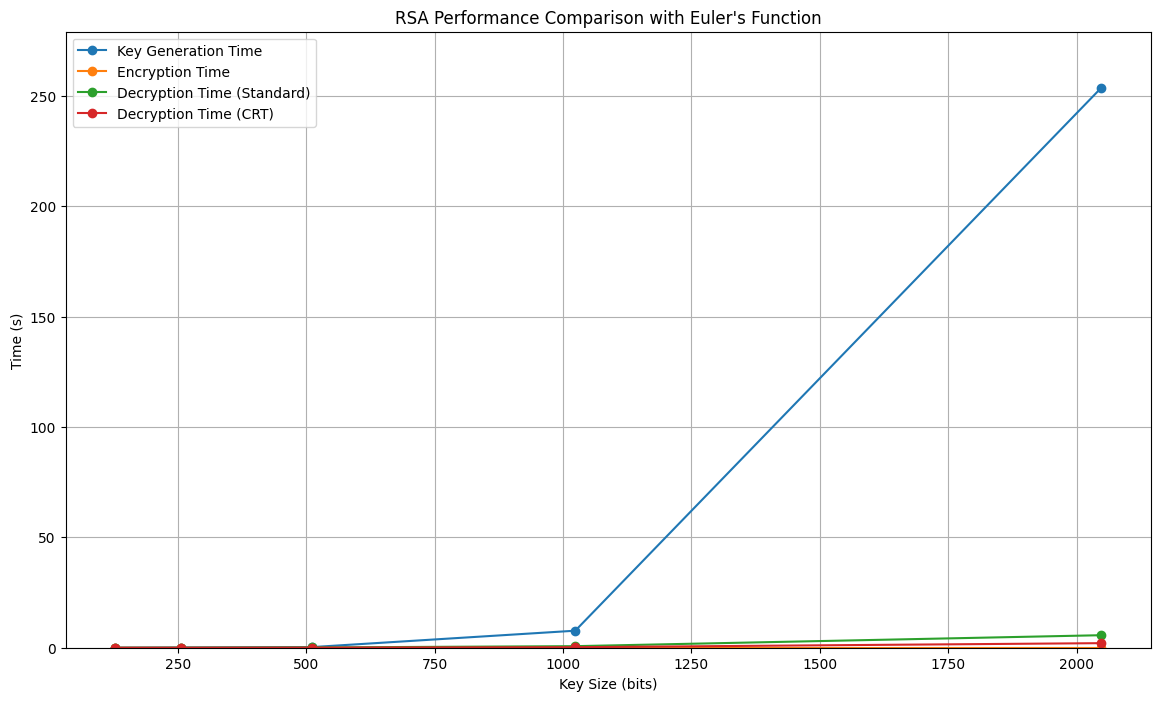

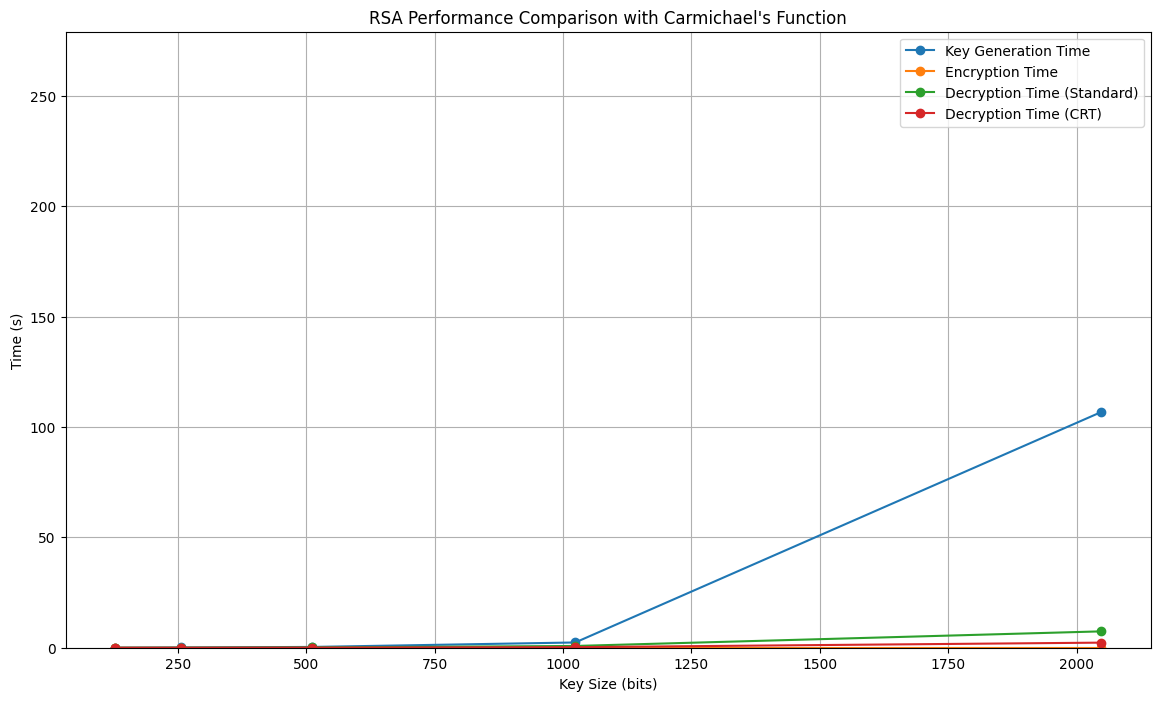

In [25]:
# Plotting RSA Performance Comparison with Euler's Function in the same scale
plt.figure(figsize=(14, 8))
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Key Generation Time (s)"], marker='o', label="Key Generation Time")
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Encryption Time (s)"], marker='o', label="Encryption Time")
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Decryption Time (Standard) (s)"], marker='o', label="Decryption Time (Standard)")
plt.plot(df_performance_euler["Key Size"], df_performance_euler["Decryption Time (CRT) (s)"], marker='o', label="Decryption Time (CRT)")
plt.xlabel("Key Size (bits)")
plt.ylabel("Time (s)")
plt.ylim(0, max(df_performance_euler["Key Generation Time (s)"].max(), df_performance_carmichael["Key Generation Time (s)"].max()) * 1.1)
plt.title("RSA Performance Comparison with Euler's Function")
plt.legend()
plt.grid(True)
plt.show()

# Plotting RSA Performance Comparison with Carmichael's Function in the same scale
plt.figure(figsize=(14, 8))
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Key Generation Time (s)"], marker='o', label="Key Generation Time")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Encryption Time (s)"], marker='o', label="Encryption Time")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Decryption Time (Standard) (s)"], marker='o', label="Decryption Time (Standard)")
plt.plot(df_performance_carmichael["Key Size"], df_performance_carmichael["Decryption Time (CRT) (s)"], marker='o', label="Decryption Time (CRT)")
plt.xlabel("Key Size (bits)")
plt.ylabel("Time (s)")
plt.ylim(0, max(df_performance_euler["Key Generation Time (s)"].max(), df_performance_carmichael["Key Generation Time (s)"].max()) * 1.1)
plt.title("RSA Performance Comparison with Carmichael's Function")
plt.legend()
plt.grid(True)
plt.show()
